In [5]:
import json
import pandas as pd
from itertools import islice
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
from scipy.stats import skellam

In [6]:
def parse_2022():
    filename = './data/archive/2022.worldcup.quolification.output.jl'
    with open(filename) as f:
        data = pd.read_json(f.read(), lines=True)
    return data
data_2022 = parse_2022()
data_2022.rename(columns = {'team0':'home_team', 'team1':'away_team', 'score0': 'home_score', 'score1': 'away_score'}, inplace = True)
# area_and_stage = data_2022['area'].str.split(',', expand=True)
print(data_2022)

def parse_2002_to_2018():
    filename = './data/archive/2002-2018.worldcup.quolification.output.jl'
    with open(filename) as f:
        data = pd.read_json(f.read(), lines=True)
    return data

data_before = parse_2002_to_2018()
data_before.rename(columns = {'team0':'home_team', 'team1':'away_team', 'score0': 'home_score', 'score1': 'away_score'}, inplace = True)
print(data_before)


     year               area                  date   home_team    away_team  \
0    2022  UEFA, Group Stage    November 16, 2021    Gibraltar       Latvia   
1    2022     AFC, Round Two    September 5, 2019     Thailand      Vietnam   
2    2022   CAF, First Round   September 10, 2019     Eswatini     Djibouti   
3    2022  UEFA, Group Stage       March 27, 2021   Montenegro    Gibraltar   
4    2022           CONMEBOL     October 10, 2021    Venezuela      Ecuador   
..    ...                ...                   ...         ...          ...   
719  2022  UEFA, Group Stage    November 16, 2021      Finland       France   
720  2022  UEFA, Group Stage    September 4, 2021     Slovakia      Croatia   
721  2022     AFC, Round Two     October 10, 2019      IR Iran     Cambodia   
722  2022  UEFA, Group Stage    September 5, 2021      Albania      Hungary   
723  2022   AFC, Round Three     October 12, 2021      IR Iran  South Korea   

     home_score  away_score                   place

In [7]:
def parse_eufa(file_path="data/data.txt"):
    data = list()
    with open(file_path, mode='r', encoding='utf-8') as f:
        skip_start_line = 3
        for line in islice(f, skip_start_line, None):
            fields = line.strip().split('\t')
            data.append(fields)

    return data


def parse_arc_data(result_file_path="data/archive/results.csv", shootout_file_path="data/archive/shootouts.csv"):
    data = list()

    with open(result_file_path, mode='r', encoding='utf-8') as f:
        skip_start_line = 39701
        for line in islice(f, skip_start_line, None):
            fields = line.strip().split(',')

            # Add winner
            if fields[3] > fields[4]:
                fields.append(fields[1])
            elif fields[3] < fields[4]:
                fields.append(fields[2])
            else:
                fields.append("None")

            data.append(fields)

    with open(shootout_file_path, mode='r', encoding='utf-8') as f:
        skip_start_line = 403
        for line in islice(f, skip_start_line, None):
            date, ctry1, ctry2, winner = line.strip().split(',')

            for i in range(0, len(data)):
                if data[i][-1] == "None" and date == data[i][0]:
                    if (ctry1 == data[i][1] and ctry2 == data[i][2]) or (ctry1 == data[i][2] and ctry2 == data[i][1]):
                            data[i][-1] = winner
                    else:
                        continue

    return data


In [8]:
eufa_record = parse_eufa()
# print(eufa_record[0])

eufa_record_field_name = ['Date', 'Location', 'Country1', 'Country2', 'Score', 'Winner']
eufa_df = pd.DataFrame(eufa_record, columns =eufa_record_field_name)
print(eufa_df)

          Date     Location         Country1         Country2    Score  \
0   06/11/2021        Italy           Turkey            Italy      0:3   
1   06/12/2021   Azerbaijan            Wales      Switzerland      1:1   
2   06/12/2021      Denmark          Denmark          Finland      0:1   
3   06/12/2021       Russia          Belgium           Russia      3:0   
4   06/13/2021      England          England          Croatia      1:0   
5   06/13/2021      Romania          Austria  North Macedonia      3:1   
6   06/13/2021  Netherlands      Netherlands          Ukraine      3:2   
7   06/14/2021     Scotland         Scotland          Czechia      0:2   
8   06/14/2021       Russia           Poland         Slovakia      1:2   
9   06/14/2021        Spain            Spain           Sweden      0:0   
10  06/15/2021      Hungary          Hungary         Portugal      0:3   
11  06/15/2021      Germany           France          Germany      1:0   
12  06/16/2021       Russia          F

In [9]:
acr_record = parse_arc_data()
# print(acr_record[0])
# for record in acr_record:
#     if len(record) != 10:
#         print(record)

acr_record_field_name = ['date', 'home_team', 'away_team', 'home_score', 'away_score', 'tournament', 'city', 'country', 'neutral', 'winner']

acr_df = pd.DataFrame(acr_record, columns =acr_record_field_name)
acr_df['home_score'] = acr_df['home_score'].astype(int)
acr_df['away_score'] = acr_df['away_score'].astype(int)
print(acr_df)

            date        home_team             away_team  home_score  \
0     2018-01-02             Iraq  United Arab Emirates           0   
1     2018-01-02             Oman               Bahrain           1   
2     2018-01-05             Oman  United Arab Emirates           0   
3     2018-01-07          Estonia                Sweden           1   
4     2018-01-11          Denmark                Sweden           0   
...          ...              ...                   ...         ...   
3716  2022-03-30           Mexico           El Salvador           2   
3717  2022-03-30       Costa Rica         United States           2   
3718  2022-03-30           Panama                Canada           1   
3719  2022-03-30          Jamaica              Honduras           2   
3720  2022-03-30  Solomon Islands           New Zealand           0   

      away_score                    tournament         city  \
0              0                      Gulf Cup  Kuwait City   
1              0     

In [10]:
score_upperbound = 10
print(acr_df[acr_df['home_score'] > score_upperbound])
print(acr_df[acr_df['away_score'] > score_upperbound])

            date            home_team                 away_team  home_score  \
523   2018-09-08                 Cuba  Turks and Caicos Islands          11   
557   2018-09-10                Haiti              Sint Maarten          13   
641   2018-10-12              Bermuda              Sint Maarten          12   
1426  2019-07-15      Solomon Islands            American Samoa          13   
1433  2019-07-18        New Caledonia                    Tuvalu          11   
1712  2019-10-10                 Iran                  Cambodia          14   
1862  2019-11-10  Trinidad and Tobago                  Anguilla          15   
2532  2021-03-30                Japan                  Mongolia          14   
2652  2021-06-05               Panama                  Anguilla          13   

      away_score                             tournament            city  \
523            0  CONCACAF Nations League qualification          Havana   
557            0  CONCACAF Nations League qualification  Po

In [11]:
score_upperbound = 20
# print(acr_df[acr_df['home_score'].astype(int) > score_upperbound])

acr_df = acr_df.drop(acr_df[acr_df['home_score'] > score_upperbound].index)
acr_df = acr_df.drop(acr_df[acr_df['away_score'] > score_upperbound].index)
acr_df.describe()

,home_score,away_score
count,3721.000000,3721.000000
mean,1.613276,1.085461
std,1.704083,1.334088
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,15.000000,14.000000


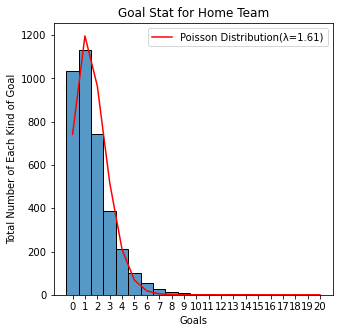

In [12]:
plt.figure(figsize=(5, 5))

x = list(range(0, score_upperbound + 1, 1))
y = list(acr_df['home_score'])

sns.histplot(data=y, discrete=True)
plt.xticks(x)
plt.xticks(np.arange(0, score_upperbound + 1, 1))
plt.title('Goal Stat for Home Team')
plt.ylabel('Total Number of Each Kind of Goal')
plt.xlabel('Goals')

lambda_home = acr_df['home_score'].mean()
plt.plot(np.arange(score_upperbound + 1), poisson.pmf(np.arange(0, score_upperbound + 1, 1), lambda_home)*acr_df.shape[0], label="Poisson Distribution(λ={:.2f})".format(lambda_home), color="red")

plt.legend()
plt.show()

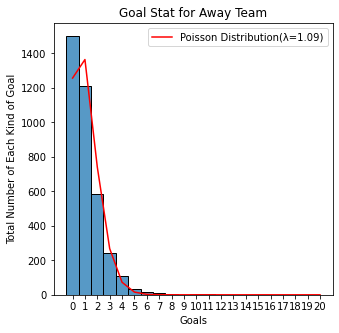

In [13]:
plt.figure(figsize=(5, 5))

x = list(range(0, score_upperbound + 1, 1))
y = list(acr_df['away_score'])

sns.histplot(data=y, discrete=True)
plt.xticks(x)
plt.title('Goal Stat for Away Team')
plt.ylabel('Total Number of Each Kind of Goal')
plt.xlabel('Goals')

lambda_away = acr_df['away_score'].mean()
plt.plot(np.arange(score_upperbound + 1), poisson.pmf(np.arange(0, score_upperbound + 1, 1), lambda_away)*acr_df.shape[0], label="Poisson Distribution(λ={:.2f})".format(lambda_away), color="red")

plt.legend()
plt.show()

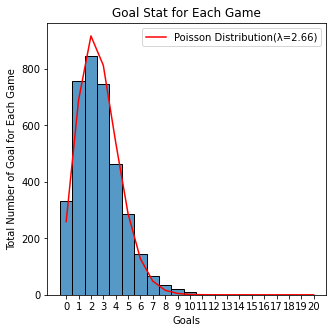

In [57]:
plt.figure(figsize=(5, 5))

x = list(range(0, score_upperbound + 1, 1))
y = acr_df.home_score + acr_df.away_score
y = y[y<11]

sns.histplot(data=y, discrete=True)
plt.xticks(x)
plt.title('Goal Stat for Each Game')
plt.ylabel('Total Number of Goal for Each Game')
plt.xlabel('Goals')

lambda_total = y.mean()
plt.plot(np.arange(score_upperbound + 1), poisson.pmf(np.arange(0, score_upperbound + 1, 1), lambda_total)*y.shape[0], label="Poisson Distribution(λ={:.2f})".format(lambda_total), color="red")

plt.legend()
plt.show()

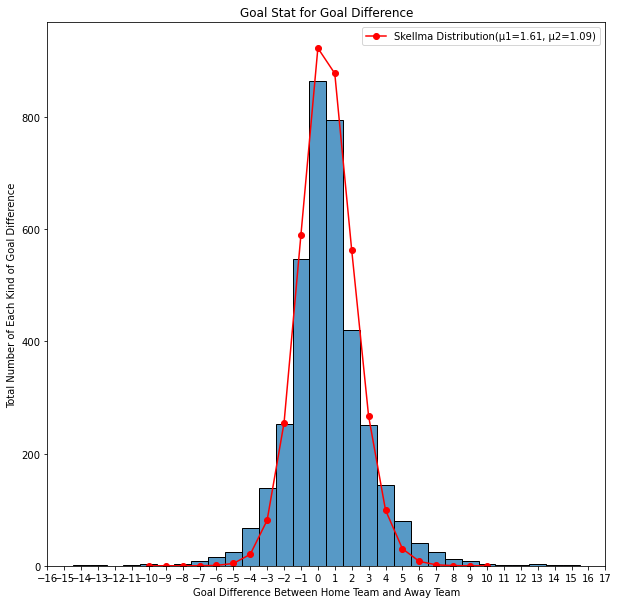

In [14]:
plt.figure(figsize=(10, 10))

x = list(range(score_upperbound * -1, score_upperbound + 1, 1))
y = list(acr_df['home_score'] - acr_df['away_score'])

sns.histplot(data=y, discrete=True)
plt.xticks(x)
plt.xticks(np.arange(score_upperbound * -1, score_upperbound + 1, 1))
plt.title('Goal Stat for Goal Difference')
plt.ylabel('Total Number of Each Kind of Goal Difference')
plt.xlabel('Goal Difference Between Home Team and Away Team')

plt.plot(np.arange(score_upperbound/2 * -1, score_upperbound/2 + 1), skellam.pmf(np.arange(score_upperbound/2 * -1, score_upperbound/2 + 1, 1), lambda_home, lambda_away)*acr_df.shape[0], '-o', label="Skellma Distribution(μ1={:.2f}, μ2={:.2f})".format(lambda_home, lambda_away), color="red")

plt.legend()
plt.show()

In [15]:
acr_df

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,winner
0,2018-01-02,Iraq,United Arab Emirates,0,0,Gulf Cup,Kuwait City,Kuwait,TRUE,None
1,2018-01-02,Oman,Bahrain,1,0,Gulf Cup,Kuwait City,Kuwait,TRUE,Oman
2,2018-01-05,Oman,United Arab Emirates,0,0,Gulf Cup,Kuwait City,Kuwait,TRUE,None
3,2018-01-07,Estonia,Sweden,1,1,Friendly,Abu Dhabi,United Arab Emirates,TRUE,None
4,2018-01-11,Denmark,Sweden,0,1,Friendly,Abu Dhabi,United Arab Emirates,TRUE,Sweden
...,...,...,...,...,...,...,...,...,...,...
3716,2022-03-30,Mexico,El Salvador,2,0,FIFA World Cup qualification,Mexico City,Mexico,FALSE,Mexico
3717,2022-03-30,Costa Rica,United States,2,0,FIFA World Cup qualification,San José,Costa Rica,FALSE,Costa Rica
3718,2022-03-30,Panama,Canada,1,0,FIFA World Cup qualification,Panama City,Panama,FALSE,Panama
3719,2022-03-30,Jamaica,Honduras,2,1,FIFA World Cup qualification,Kingston,Jamaica,FALSE,Jamaica


In [42]:
df = pd.read_csv('data/archive/results.csv')
grouped = df.groupby('tournament')
world_cup_df = grouped.get_group('FIFA World Cup')
number_of_goals = world_cup_df.home_score + world_cup_df.away_score
number_of_goals = number_of_goals[number_of_goals <= 10]
number_of_goals

1314     3
1315     5
1316     3
1317     4
1318     1
        ..
40129    4
40130    1
40131    3
40132    2
40133    6
Length: 896, dtype: int64

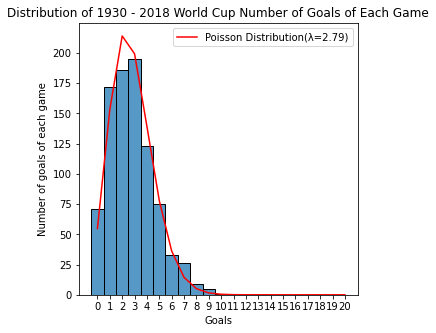

In [55]:
plt.figure(figsize=(5, 5))
score_upperbound = 20
x = list(range(0, score_upperbound + 1, 1))

sns.histplot(data=number_of_goals, discrete=True)
plt.xticks(x)
plt.xticks(np.arange(0, score_upperbound + 1, 1))
plt.title('Distribution of 1930 - 2018 World Cup Number of Goals of Each Game')
plt.ylabel('Number of goals of each game')
plt.xlabel('Goals')

lambda_world_cup_number_of_goals = number_of_goals.mean()
plt.plot(np.arange(score_upperbound + 1), poisson.pmf(np.arange(0, score_upperbound + 1, 1), lambda_world_cup_number_of_goals)*number_of_goals.shape[0], label="Poisson Distribution(λ={:.2f})".format(lambda_world_cup_number_of_goals), color="red")

plt.legend()
plt.show()